In [35]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
from shapely import box
from scipy.stats import norm
import config.settings as cset

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            )

from tqdm.notebook import tqdm


plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['hatch.linewidth'] = cset.hatch_linewidth 
# Set global linewidth for all plotted lines
mpl.rcParams['lines.linewidth'] = cset.linewidth  # adjust as needed

# Set global linewidth for figure borders (spines)
mpl.rcParams['axes.linewidth'] = cset.border_linewidth   # frame around plots
mpl.rcParams['xtick.labelsize'] = labelsize_small
mpl.rcParams['ytick.labelsize'] = labelsize_small
mpl.rcParams['axes.labelsize'] = labelsize_medium
mpl.rcParams['axes.titlesize'] = labelsize_large
mpl.rcParams['legend.fontsize'] = labelsize_medium

mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1


In [36]:
# Function to extract per-ensemble-member country median for each scenario group
def get_ensemble_medians(df, dataset_label):
    rows = []
    for scenario_prefix in cset.scenarios:  # Add more as needed
        scenario_cols = [col for col in df.columns if col.startswith(scenario_prefix)]
        for col in scenario_cols:
            country_median = df[col].median()
            rows.append({
                'Scenario': scenario_prefix,
                'EnsembleMember': col,
                'MedianValue': country_median,
                'Dataset': dataset_label
            })
    return pd.DataFrame(rows)

## Settings

In [37]:
thrshld = 1.35
thrshld_str = '135'
gmt_char = 'gmt_ntwr'

In [38]:
damage_fn_markers = {
    label: marker for label, marker in zip(
        cset.GDP_labels,
        ['s', 'o', 'd']  # Extend this list if needed
    )
}
linestyles = dict(zip(cset.GDP_labels, [(0, (1,1)), '-', (0, (5,1))]))

current_warming_rate_median = 0.27
current_warming_rate_ranges = [0.2,0.4]

## Load Data

In [39]:
peak_gdp_impacts = [pd.read_csv(cset.path_OUT_PW / file) for file in cset.PW_dataset_names]
gmt_char_df = pd.read_csv(cset.path_MESMER_char / f'gmt_characteristics_thsld_{thrshld_str}.csv', index_col = 0)
gmt_char_df['gmt_ntwr'] *= 10 # convert to °C/decade
gmt_char_df['gmt_ltwr'] *= 10 # convert to °C/decade

## Generate Results for Plotting

In [40]:
# Combine medians for all datasets
ensemble_medians_df = pd.concat([
    get_ensemble_medians(df, f'{cset.GDP_labels[i]}')
    for i, df in enumerate(peak_gdp_impacts)
])

# plotting mean warming between 2015-2030 against median GDP impacts dring peak warming year 
ensemble_medians_df['gmt_ntwr'] = gmt_char_df.loc[ensemble_medians_df.EnsembleMember.values, 'gmt_ntwr'].values # warming per decade
ensemble_medians_df['gmt_ltwr'] = gmt_char_df.loc[ensemble_medians_df.EnsembleMember.values, 'gmt_ltwr'].values # warming per decade
ensemble_medians_df['MedianValue'] *= 100 # convert to percent

In [41]:
## Store Results
quantiles = [0.05, 0.5, 0.95]
df = ensemble_medians_df.copy()
df['MedianValue'] -= 100
summary_df = (
    df
    .groupby(['Scenario', 'Dataset'])['MedianValue']
    .quantile(quantiles)
    .unstack(level=-1)  # move quantiles from index to columns
    .reset_index()
    .rename(columns={0.05: 'q05', 0.5: 'median', 0.95: 'q95'})
    .round(1)
)
del df

In [43]:
classification_dfs = [pd.read_csv(cset.path_CLUSTER_results / f'Classification_{file_name}') for file_name in cset.GDP_interim_dataset_names]

## Plotting Functions

### Boxplot

In [45]:

def gdp_boxplot(ax, df, ylabel='GDP change relative to basline (%)', xlabel=cset.GDP_labels[0], scenarios = cset.focus_scenarios, dataset = cset.GDP_labels[0], yticks = None, ylim = None, insert_ax = False):
    plot_df = df[df.Dataset == dataset].copy()
    plot_df['MedianValue'] -= 100
    flier_props = dict(marker='o', markersize=cset.marker_size/2, linestyle='none', markeredgewidth=cset.marker_edgewidth)
    sns.boxplot(data=plot_df[plot_df.Scenario.isin(scenarios)],
                x='Dataset',
                y='MedianValue',
                hue='Scenario',
                palette=cset.scenarios_color_dict,
                notch=True,
                linewidth=0.5,
                flierprops=flier_props,
                ax=ax
               )
    ax.set_ylabel(ylabel, fontsize=labelsize_medium)
    ax.set_xlabel(xlabel, fontsize=labelsize_medium)
    ax.set_xticks([])
    if yticks is not None:
        ax.set_yticks(yticks)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='major', labelsize=labelsize_small)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize_small)
    ax.legend().set_visible(False)
    
    if insert_ax == True: 
        inset_ax = ax.inset_axes([0.005, 0.02, 0.3, 0.5])
        boxplot_legend(inset_ax)
    return

def boxplot_legend(inset_ax):
    dummy_data = norm.rvs(0, 1.5, size=1000)
        
    bplot = inset_ax.boxplot(dummy_data,
                            positions=[0],
                            widths=0.2,
                            notch=True,
                            patch_artist=True)

    inset_ax.axis('off')

    for patch in bplot['boxes']:
        patch.set_facecolor('lightgrey')
        patch.set_edgecolor('black')
        patch.set_linewidth(cset.border_linewidth/2)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element == 'fliers':
            plt.setp(bplot[element], color='black', markeredgewidth=0.5, markersize=cset.marker_size/2)
        elif element == 'caps':
            plt.setp(bplot[element], color='black', markersize=cset.linewidth, markeredgewidth=0.5, lw=0.5)
        elif element == 'medians':
            plt.setp(bplot[element], color='black', linewidth=0.5)
        else:
            plt.setp(bplot[element], color='black', linewidth=0.4)

    inset_ax.text(0.25, 6, 'Outliers', fontsize=labelsize_small, va='center', ha='left')
    inset_ax.text(0.25, 4, 'Min/max range', fontsize=labelsize_small, va='center', ha='left')
    inset_ax.text(0.25, 2, 'Interquartile range', fontsize=labelsize_small, va='center', ha='left')
    inset_ax.text(0.25, 0, 'Median', fontsize=labelsize_small, va='center', ha='left')

    inset_ax.plot([0.1, 0.22], [5.55, 6], color='black', lw=0.5)
    inset_ax.plot([0.05, 0.22], [3.4, 4], color='black', lw=0.5)
    inset_ax.plot([0.12, 0.22], [1.2, 2], color='black', lw=0.5)
    return()

### Scatter plots

In [46]:
def climate_sensitivity_2Dscatter_singleDF(ax, df, dataset, marker, linestyle, xlabel='Warming rate \n 2015-2030 (°C/decade)', ylabel='GDP change relative to baseline (%)', scenarios = cset.focus_scenarios):
    colors = cset.focus_scenarios_color_dict
    # scenarios = cset.focus_scenarios

    for scenario in scenarios:
        scenario_subset = df[
            (df['Dataset'] == dataset) &
            (df['Scenario'] == scenario)
        ].copy()
        scenario_subset['MedianValue'] -= 100  
        x_vals = scenario_subset['gmt_ntwr'].values
        y_vals = scenario_subset['MedianValue'].values

        ax.scatter(
            x_vals, y_vals,
            color=colors[scenario],
            marker=marker,
            alpha = .7,
            label=f'{scenario}',
            s=cset.marker_size*2,
            edgecolor = 'none'
        )

        # Optional linear fit
        if len(x_vals) > 1:
            model = LinearRegression()
            model.fit(x_vals.reshape(-1, 1), y_vals)
            x_fit = np.linspace(x_vals.min(), x_vals.max(), 100)
            y_fit = model.predict(x_fit.reshape(-1, 1))
            ax.plot(
                x_fit, y_fit,
                color=colors[scenario],
                linewidth=cset.linewidth,
                linestyle = linestyle
            )
            
            # from scipy import stats
            # slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
            # print(r_value, p_value)
            
    ax.axvspan(current_warming_rate_ranges[0], current_warming_rate_ranges[1],
               color='grey', alpha=0.2,linewidth=0 )
    ax.axvline(current_warming_rate_median, color='grey', linestyle='-', lw = cset.border_linewidth, alpha=0.5)

    ax.set_yticks([-75, -50, -25,  0])
    ax.set_xticks([.1, .2, .3, .4, .5])
    ax.set_ylim([-85, 20])

    ax.set_xlabel(xlabel, fontsize=labelsize_medium)
    ax.set_ylabel(ylabel, fontsize=labelsize_medium)
    ax.tick_params(axis='both', labelsize=labelsize_small)

    legend_handles = []
    for label in cset.GDP_labels: 
        marker_handle =  Line2D([0], [0], marker=damage_fn_markers[label], linestyle = '', color='darkgrey', markersize = cset.marker_size/2)
        line_handle =  Line2D([0], [0], marker='', linestyle= linestyles[label], color='darkgrey')
        legend_handles.append(
            (marker_handle, line_handle)
        )
                    
    legend = ax.legend(legend_handles, 
              cset.GDP_labels, 
              loc='lower left', 
              frameon=True, 
              title = 'Data/Fit',
              fontsize=labelsize_small,
              edgecolor = 'none', 
              facecolor = (1,1,1,0.7), 
              handlelength=3, 
              bbox_to_anchor = (0.01,0.01), 
              handler_map={tuple: HandlerTuple(ndivide=None)})
    legend.get_title().set_fontsize(labelsize_medium)
    return

In [58]:
def climate_sensitivity_2Dscatter(ax, df, scenarios = ['CurPol'], xlabel='Warming rate \n 2015-2030 (°C/decade)', ylabel='GDP change relative to baseline (%)'):
    colors = cset.focus_scenarios_color_dict
    legend_handles = []
    for scenario in scenarios:
        for dataset in cset.GDP_labels:
            marker = damage_fn_markers[dataset]
            scenario_subset = df[
                (df['Dataset'] == dataset) &
                (df['Scenario'] == scenario)
            ].copy()
            scenario_subset['MedianValue'] -= 100  
            x_vals = scenario_subset['gmt_ntwr'].values
            y_vals = scenario_subset['MedianValue'].values

            ax.scatter(
                x_vals, y_vals,
                color=colors[scenario],
                marker=marker,
                alpha = .7,
                label=f'{scenario} – {dataset}',
                s=cset.marker_size*2,
                edgecolor = 'none'
            )

            # Optional linear fit
            if len(x_vals) > 1:
                model = LinearRegression()
                model.fit(x_vals.reshape(-1, 1), y_vals)
                x_fit = np.linspace(x_vals.min(), x_vals.max(), 100)
                y_fit = model.predict(x_fit.reshape(-1, 1))
                ax.plot(
                    x_fit, y_fit,
                    color=colors[scenario],
                    linewidth=cset.linewidth,
                    linestyle = linestyles[dataset]
                )
    ax.axvspan(current_warming_rate_ranges[0], current_warming_rate_ranges[1],
               color='grey', alpha=0.2,
                linewidth=0)
    ax.axvline(current_warming_rate_median, color='grey', linestyle='-', lw = cset.border_linewidth, alpha=0.5)

    
    ax.set_xlabel(xlabel, fontsize=labelsize_medium)
    ax.set_ylabel(ylabel, fontsize=labelsize_medium)
    ax.tick_params(axis='both', labelsize=labelsize_small)
    
    ax.set_yticks([-75, -50, -25,  0])
    ax.set_xticks([.1, .2, .3, .4])
    ax.set_ylim([-85, 20])
    return



### Stylised GDP

In [48]:
def stylised_gdp_categories(ax):
    years = np.arange(2015,2101,1)
    y_growth_accelerating     = 0.13*np.exp(0.04*(years-2015))-1.63
    y_growth_constant         = 0.041*(years-2015)-1.5
    y_growth_slowing          = 1.4*np.log(0.1*(years-2014)+0.9)-1.5
    y_growth_complex          = 2.23827367*10**(-12)*years**5  - 6.40624342*10**(-9)*years**4 - 7.56066177*10**(-6)*years**3 +  1.53649475*10**(-2)*years**2 + 5.54010968*10**1*years - 8.09050281*10**4
    y_stagnation_normal       = -0.000533*(years-2015)**2+0.069*(years-2015)-1.5
    y_stagnation_normal[63:]  = 0.73
    y_stagnation_complex      = 3.032952801004872e-08*years**5-0.0003133029502560941*years**4+1.2944615357045461*years**3-2673.926959661213*years**2+2761503.1360722124*years-1140688424.188846-0.78
    y_nogrowth_normal           = -0.00066115702*(years-2015)**2+0.07272727272*(years-2015)-1.5
    y_nogrowth_complex          = 7.697877562439336e-08*years**5 + -0.000793981717365918*years**4 + 3.275521122253075*years**3 + -6756.016333993602*years**2 + 6966928.2130272165*years**1 + -2873573436.7270246-1.5

    colors_clusters = colors = ['teal', 
                                'orange', 
                                'mediumpurple']
    default_linewidth = cset.linewidth
    
    ax.plot(years, y_growth_constant, linewidth = default_linewidth, color = colors_clusters[0], label = 'Growth')
    ax.plot(years, y_stagnation_normal, linewidth = default_linewidth, color = colors_clusters[1], label = 'Stagnation')
    ax.plot(years, y_nogrowth_normal, linewidth = default_linewidth, color = colors_clusters[2], label = 'Decline')
    
    ax.set_ylim(bottom = -2, top = 2.2)
    ax.set_yticks([])
    ax.set_xticks([2020,2040,2060,2080,2100],
                  [2020,2040,2060,2080,2100], 
                  fontsize = labelsize_small) 
    ax.set_ylabel('GDP',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Year', 
                  fontsize = labelsize_large)
    ax.legend(edgecolor = 'none', 
              facecolor = (1,1,1,.7), 
              fontsize = labelsize_small,
              ncols = 1, 
              loc = 'upper left',)  
    return()

### Categories and Map 

In [49]:
# Scenarios of interest
scenarios = ['CurPol', 'GS', 'Ref']
def declining_gdp_single_panel(ax, classification_dfs, scenarios, damage_labels = cset.GDP_labels):
    bin_edges = [-np.inf, 0.15, 0.3, np.inf]
    bin_labels = ['<0.15°C', '0.15°C-0.3°C', '>0.3°C']
    
    bar_width = 0.28           # was 0.2
    scenario_gap = 0.0         # same
    bin_gap = 0.12             # was 0.3
    damage_gap = 1.2           # was 0.6
    
    # bar_width = 0.2
    # scenario_gap = 0.0             # gap between scenario bars in a group
    # bin_gap = 0.3                  # small gap between warming bins
    # damage_gap = 0.6               # larger gap between damage function types
    
    
    n_scenarios = len(scenarios)

    # Step 1: Prepare data
    plot_data = []
    for d_idx, classification_df in enumerate(classification_dfs):
        classification_df = classification_df.reset_index(drop=True).rename_axis(None, axis=1).copy()
        classification_df['scen_run'] = classification_df['scen'] + '_' + classification_df['run'].astype(str)

        result_df = pd.DataFrame(index=classification_df['scen_run'].unique())
        result_df['nogrowth'] = classification_df[classification_df['category'] == 'nogrowth'].groupby('scen_run').size()
        result_df['nogrowth'] = result_df['nogrowth'].fillna(0)
        result_df[gmt_char] = gmt_char_df.loc[result_df.index, gmt_char].values
        result_df['scen'] = [sr.split('_')[0] for sr in result_df.index]
        result_df['gmt_bin'] = pd.cut(result_df[gmt_char], bins=bin_edges, labels=bin_labels, include_lowest=True)

        for bin_label in bin_labels:
            for scen in scenarios:
                mask = (result_df['scen'] == scen) & (result_df['gmt_bin'] == bin_label)
                share = result_df.loc[mask, 'nogrowth'].astype(float).mean()/157*100
                plot_data.append({
                    'damage': damage_labels[d_idx],
                    'bin': bin_label,
                    'scenario': scen,
                    'value': share if pd.notna(share) else 0
                })

    # Step 2: Create x-positions with grouped spacing
    xpos_lookup = {}
    x_positions = []
    current_x = 0
    damage_label_positions = []

    for d_label in damage_labels:
        bin_label_positions = []

        for b_label in bin_labels:
            scen_positions = []
            for s in scenarios:
                key = (d_label, b_label, s)
                xpos_lookup[key] = current_x
                x_positions.append(current_x)
                current_x += bar_width + scenario_gap
                scen_positions.append(current_x)

            # Small gap between bins
            current_x += bin_gap

            # Save center position for bin group
            bin_label_positions.append(np.mean(scen_positions))

        # Larger gap between damage groups
        damage_label_positions.append(np.mean(bin_label_positions))
        current_x += damage_gap

    # Step 3: Plot bars
    for entry in plot_data:
        x = xpos_lookup[(entry['damage'], entry['bin'], entry['scenario'])]
        ax.bar(
            x,
            entry['value'],
            width=bar_width,
            color=cset.focus_scenarios_color_dict[entry['scenario']],
            label=entry['scenario']
        )

    # Step 4: Format x-axis ticks
    # Warming bin tick positions
    bin_ticks = []
    bin_ticklabels = []
    for d_label in damage_labels:
        for b_label in bin_labels:
            bin_positions = [
                xpos_lookup[(d_label, b_label, s)]
                for s in scenarios
            ]
            bin_ticks.append(np.mean(bin_positions))
            bin_ticklabels.append(b_label)

    ax.set_xticks(bin_ticks)
    ax.set_xticklabels(bin_ticklabels, fontsize=labelsize_small)
    ax.set_xlabel('Warming rate 2015-2030 (°C/decade)', fontsize=labelsize_medium)
    # # Step 5: Damage function group labels
    secax = ax.secondary_xaxis('top')
    # Set tick positions and labels on the secondary axis
    secax.set_xticks(damage_label_positions)
    secax.set_xticklabels(damage_labels, fontsize=labelsize_medium)
    secax.tick_params(axis='x', which='both', length=0)
    
    # secax.set_xlabel('Damage function', fontsize=labelsize_medium, labelpad = 3)
    # Optionally style the secondary axis
    # Optionally style the secondary axis
    # secax.tick_params(axis='x', length=0)  # hide ticks, only labels remain
    secax.spines['top'].set_visible(False)  # hide the top spine (line)

    # Remove grid or ticks if needed
    secax.grid(False)

    # y_min, y_max = ax.get_ylim()
    # for xpos, d_label in zip(damage_label_positions, damage_labels):
    #     ax.text(xpos, 0.95, d_label,
    #             ha='center', va='top', fontsize=labelsize_medium,
    #             transform=ax.get_xaxis_transform(), fontweight = 'bold')

    # Step 6: Styling
    ax.set_ylabel('Share of countries\nwith GDP decline (%)', fontsize=labelsize_medium)
    ax.set_ylim(0, max([d['value'] for d in plot_data]) * 1.2)
    ax.tick_params(axis='y', labelsize=labelsize_small)
    ax.set_xlim(-0.2, 6.8)

    # Step 7: Clean legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=labelsize_small,
    #           frameon=True, edgecolor='none', facecolor=(1, 1, 1, 0.8))

    return


def declining_gdp_worldmap(ax, scenario, classification_df):
    # Load world geometries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
    world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
    world.index = world.iso_a3

    # Build binary GDP decline indicator
    classification_counts_df = classification_df[['scen', 'iso', 'category']].copy()
    classification_counts_df['category_binary'] = 0
    classification_counts_df.loc[classification_counts_df.category == 'nogrowth', 'category_binary'] = 1
    classification_counts_df = classification_counts_df.groupby(['scen', 'iso'])['category_binary'].sum().reset_index()

    gdp_isos = classification_counts_df.iso.unique()
    for scen in cset.scenarios:
        world[f'no_growth_count_{scen}'] = np.nan
        world.loc[gdp_isos, f'no_growth_count_{scen}'] = classification_counts_df.loc[classification_counts_df.scen == scen, 'category_binary'].values

    # Plot settings
    column = f'no_growth_count_{scenario}'
    cmap2 = LinearSegmentedColormap.from_list('cmap2', ['whitesmoke', cset.focus_scenarios_color_dict[scenario]])
    cmap2.set_under('whitesmoke')
    cmap2.set_bad('lightgrey')

    # Ensure CRS is Mollweide and geometries are projected
    world = world.to_crs(ccrs.Mollweide().proj4_init)

    # Plot with Cartopy projection
    ax.set_global()
    ax.coastlines(color='gray', linewidth=0.5)
    # ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    # ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='lightgray')

    # Plot geopandas data onto cartopy axis
    world.plot(
        ax=ax,
        column=column,
        cmap=cmap2,
        vmin=0,
        edgecolor='gray',
        linewidth=cset.border_linewidth,
        transform=ccrs.Mollweide(),
        legend=False  # legend added manually below
        
    )

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(position='top', size='7%', pad=0.12, axes_class=plt.Axes)
    sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    sm._A = []  # Hack for older matplotlib versions
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    # cb.ax.xaxis.set_ticks_position('top')     # Tick marks on top
    cb.ax.xaxis.set_label_position('top')     # Label also on top
    cb.set_label(f'Risk for GDP decline under CurPol [%]', fontsize=labelsize_medium, labelpad = 3)
    cb.ax.tick_params(labelsize=labelsize_small)
    cb.ax.set_xticks([0, 25, 50, 75, 100])
    cb.ax.tick_params(axis='x', which='both', length=2)

    ax.gridlines(draw_labels=False, color='lightgray', linewidth=0.2)

    return

### Actual Plot

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


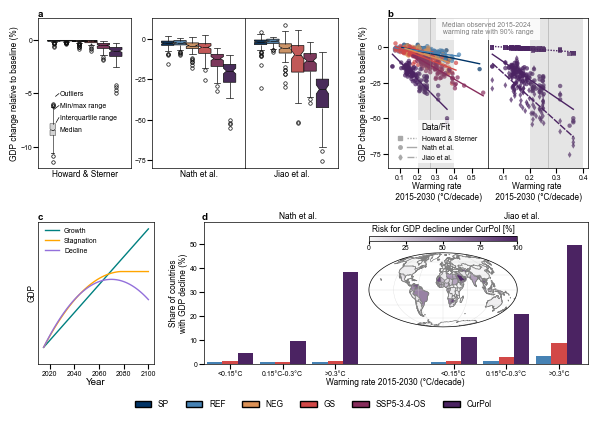

In [59]:
# Set figure
fig = plt.figure(figsize=(cset.fig_width, cset.fig_height*0.66))
axes = []
# Gridspec with two rows, height ratio: top row is 0.8x bottom row
outer = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1,1.05], hspace=.35)

# === First Row ===
gs1 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2,
    subplot_spec=outer[0],
    width_ratios=[1.5, 1],
    wspace=0.2
)

# -- left side 
gsleft = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2,
    subplot_spec=gs1[0],
    width_ratios=[1,2],
    wspace=0.15,
)
gsleft2 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2,
    subplot_spec=gsleft[1],
    width_ratios=[1,1],
    wspace=0,
)

ax1a = fig.add_subplot(gsleft[0])  # wide panel
gdp_boxplot(ax1a, 
            ensemble_medians_df, 
            ylabel = 'GDP change relative to baseline (%)', 
            xlabel = cset.GDP_labels[0], 
            scenarios = cset.focus_scenarios,
            dataset = cset.GDP_labels[0],
            yticks = [-10,-5,0],
            ylim = [-12, 2],
            insert_ax = True)
axes.append(ax1a)

ax1b = fig.add_subplot(gsleft2[0])  # wide panel
gdp_boxplot(ax1b, 
            ensemble_medians_df, 
            ylabel = '', 
            xlabel = cset.GDP_labels[1], 
            scenarios = cset.focus_scenarios,
            dataset = cset.GDP_labels[1],
            yticks = [-75,-50,-25,0]
            )
# axes.append(ax1b)

ax1c = fig.add_subplot(gsleft2[1], sharey = ax1b)  # wide panel
gdp_boxplot(ax1c, 
            ensemble_medians_df, 
            ylabel = '', 
            xlabel = cset.GDP_labels[2], 
            scenarios = cset.focus_scenarios,
            dataset = cset.GDP_labels[2]
            )
ax1c.tick_params(axis='y', which='both', left=False, labelleft=False)
# axes.append(ax1c)

# -- right side 
gsright = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2,
    subplot_spec=gs1[1],
    width_ratios=[1,1],
    wspace=0,
)

ax2a = fig.add_subplot(gsright[0])
climate_sensitivity_2Dscatter_singleDF(ax2a, ensemble_medians_df, cset.GDP_labels[1], 'o', '-', scenarios = cset.focus_scenarios)
axes.append(ax2a)

ax2b = fig.add_subplot(gsright[1], sharey = ax2a)
climate_sensitivity_2Dscatter(ax2b, ensemble_medians_df, ylabel='', scenarios = ['CurPol'])
ax2b.tick_params(axis='y', which='both', left=False, labelleft=False)
# axes.append(ax2b)

box = ax2b.text(0, 0.89, 
            'Median observed 2015-2024 \n warming rate with 90% range',
            fontsize = labelsize_small, ha='center', va='bottom',
            transform=ax2b.transAxes, 
            zorder = 20,
            color = 'grey'
            )
box.set_bbox(dict(facecolor='white', alpha=.8, edgecolor='none'))

# === Second Row ===
gs2_tmp = gridspec.GridSpecFromSubplotSpec(
    nrows=2, ncols=1,
    subplot_spec=outer[1],
    height_ratios=[1, 0.1],
    hspace=0,
)

gs2 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2,
    subplot_spec=gs2_tmp[0],
    width_ratios=[0.3, 1],
    wspace=0.2,
)

ax4 = fig.add_subplot(gs2[0])  # Narrow side panel
stylised_gdp_categories(ax4)
# pos = ax.get_position()
# # move left a bit, reduce width slightly if needed
# ax.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height-0.05])
axes.append(ax4)

ax5 = fig.add_subplot(gs2[1])  # Narrow side panel
declining_gdp_single_panel(ax5, classification_dfs[1:], ['Ref', 'GS', 'CurPol'], damage_labels=cset.GDP_labels[1:])
axes.append(ax5)

bbox = ax5.get_position()
inset_width = bbox.width * 0.62
inset_height = bbox.height * 0.64
inset_x = bbox.x0 + 0.17  # slightly to the left of ax4
inset_y = bbox.y0 + 0.08  # shift upward a bit

# Add inset axis with Mollweide projection
inset_ax = fig.add_axes(
    [inset_x, inset_y, inset_width, inset_height],
    projection=ccrs.Mollweide()
)

# inset_ax = ax4.inset_axes([ 0.02, 0.2, 0.55, 0.8], projection = ccrs.Mollweide)  # [x0, y0, width, height] in axes coords
declining_gdp_worldmap(inset_ax, 'CurPol', classification_dfs[2])
# ax6 = fig.add_subplot(gs2[2])  # Regular full-height panel

# # OPTIONAL: Add labels for clarity
for label, ax in zip(['a', 'b', 'c', 'd', 'e'], axes):
    ax.text(-0.005, 1.03, label, ha='left', va='center', fontsize=labelsize_large, fontweight='bold', transform=ax.transAxes)
 
ax = fig.add_subplot(gs2_tmp[1])
for spine in ax.spines.values():
    spine.set_visible(False)  # Hide the spines
ax.set_axis_off()
# Create custom legend elements for each scenario using colored squares (or Line2D if preferred)
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=cset.scenario_names_dict[scenario])
    for scenario, color in cset.focus_scenarios_color_dict.items()
]
ax.legend(
    handles=legend_elements,
    loc='lower center',
    frameon=False,
    fontsize= labelsize_medium,
    ncols = 6
)
pos = ax.get_position()
# move left a bit, reduce width slightly if needed
ax.set_position([pos.x0, pos.y0-0.08, pos.width, pos.height])
   
plt.savefig(cset.path_GRAPHICS / '002_until_peak_warming.pdf', dpi=cset.dpi, bbox_inches='tight')
#plt.tight_layout()
plt.show()
